In [169]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import copy

In [135]:
def edge_detection(image_location):
    # Read the original image
    img = cv2.imread(image_location)
    # img = img[500:950,100:250]
    img = img[500:1450, 100:1000]

    # Convert to graycsale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 

    # Canny Edge Detection
    # edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
    edges = cv2.Canny(image=img_blur, threshold1=200, threshold2=300) # Canny Edge Detection
    return edges

In [263]:
def shape_classifier(blob):
    # based on ratio of height and width
    x_min = 10000000
    x_max = 0
    y_min = 10000000
    y_max = 0
    
    for coor in blob:
        x_min = min([x_min, coor[0]])
        x_max = max([x_max, coor[0]])
        y_min = min([y_min, coor[1]])
        y_max = max([y_max, coor[1]])
        
    height = x_max - x_min
    width = y_max - y_min
    center = (int((x_max+x_min)/2), int((y_max+y_min)/2))
    
    bounds = ((x_min, x_max),(y_min, y_max))
    if height/width > 2:
        return 'tube', center, bounds
    else:
        return 'ball', center, bounds

In [260]:
def overlap(b0, b1):        
    if b0[0][0] >= b1[0][0] and b0[0][0] <= b1[0][1]:
        return True
    if b0[0][1] >= b1[0][0] and b0[0][1] <= b1[0][1]:
        return True
    if b0[1][0] >= b1[1][0] and b0[1][0] <= b1[1][1]:
        return True
    if b0[1][1] >= b1[1][0] and b0[1][1] <= b1[1][1]:
        return True
    else:
        return False

def proximity(c0, c1, r):
    x = abs(c0[0]-c1[0])
    y = abs(c0[1]-c1[1])
    if (x*x)+(y*y) > r*r:
        return False
    else:
        return True

In [261]:
def get_shapes(blobs):
    shape_centers = dict()
    for blob in blobs:
        shape, center, bounds = shape_classifier(blob)
        if shape not in shape_centers:
            shape_centers[shape] = list()
        
        new = True
        for other_center, other_bounds in shape_centers[shape]:
            if proximity(center, other_center, 10):
                new = False
                
        if new:
            shape_centers[shape].append((center, bounds))
        
    return shape_centers

In [198]:
def blob_finder(edge_image):
    blobs = list()
    for x in range(0, len(edge_image)):
        for y in range(0, len(edge_image[x])):
            if edge_image[x,y] == 255:
                blob, edge_image = find_line(x, y, [(x,y)], edge_image)
                blobs.append(blob)
    return blobs
            
def find_line(x, y, history, edge_image):
    x_min = max(0, x-1)
    x_max = min(len(edge_image), x+1)
    y_min = max(0, y-1)
    y_max = min(len(edge_image[0]), y+1)
#     kernel = edge_image[x_min:x_max, y_min:y_max]
    
    for i in range(x_min, x_max+1):
        for j in range(y_min, y_max+1):
            if (i,j) not in history and edge_image[i,j] == 255:
                edge_image[i,j] = 0
                history, edge_image = find_line(i, j, history+[(i,j)], edge_image)
    return history, edge_image

In [264]:
edges = edge_detection('/Users/tkim/Downloads/bs.png')
blobs = blob_finder(edges)

full_size_blobs = list()
for blob in blobs:
    if len(blob) > 200:
        full_size_blobs.append(blob)
        
shape_dict = get_shapes(full_size_blobs)

In [254]:
color_dict = dict()

color_image = cv2.imread('/Users/tkim/Downloads/bs.png')
color_image = color_image[500:1450, 100:1000]

code = 97
for ball in shape_dict['ball']:
    color = (color_image[ball][0], color_image[ball][1], color_image[ball][2])
#     print(color)
    if color not in color_dict:
        color_dict[color] = chr(code)
        code += 1

In [255]:
color_dict

{(229, 163, 85): 'a',
 (35, 42, 197): 'b',
 (66, 140, 232): 'c',
 (124, 214, 98): 'd',
 (123, 94, 234): 'e',
 (14, 150, 120): 'f',
 (101, 100, 99): 'g',
 (195, 46, 58): 'h',
 (147, 43, 114): 'i'}

In [270]:
shape_dict['tube'][0]

((219, 79), ((29, 410), (21, 138)))

In [273]:
shape_dict['ball'][0][0]

(119, 79)

In [271]:
tube_dict = dict()

for tube in shape_dict['tube']:

for tube in shape_dict['tube']:
    bounds = tube[1]
    x = bounds[0]
    y = bounds[1]
    
    for ball in shape_dict['ball']:
        ball_center = ball[0]
        if ball_center[0] >= x[0] and ball_center[0] <= x[1]:
            if ball_center[1] >= y[0] and ball_center[1] <= y[1]:
                

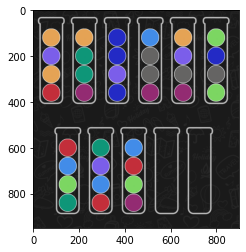

In [238]:
img = cv2.imread('/Users/tkim/Downloads/bs.png')
img = img[500:1450, 100:1000]
# plt.imshow(img[0:200,0:200])
plt.imshow(img)